In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd
# from root_numpy import array2tree


import scipy
import awkward
import numpy as np
import time
import numpy as np
from scipy.stats import norm
import math
# import CMS_lumi, tdrstyle
import sys
sys.path.append("/uscms_data/d3/christiw/MDS_CMSDAS2023/lib")
import tdrstyle
style = tdrstyle.setTDRStyle()
# CMS_lumi.writeExtraText = 0

print(sys.version)

Welcome to JupyROOT 6.28/00
3.9.12 (main, Jun  7 2022, 16:09:12) 
[GCC 11.2.0]


# Load ntuples

In [2]:
data_file = '/uscms_data/d3/christiw/MDS_CMSDAS2023/ntuples/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018B-HighMET-17Sep2018_Job9_of_20.root'
# data_file = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2016_Run2016-HighMET-07Aug17_goodLumi.root'
    
print(data_file)
root_dir = uproot.open(data_file) 
tree = root_dir['MuonSystem']
NEvents = root_dir['NEvents'].values()[0] #get first bin of histogram
print(NEvents)



/uscms_data/d3/christiw/MDS_CMSDAS2023/ntuples/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018B-HighMET-17Sep2018_Job9_of_20.root
43798.0


# OOT Control Region Selection

In [3]:
oot_flag = 1
# if 0 then do inverted cut-based ID region
T = tree
        
########### SELECTION: CLUSTERS ############


sel_rechitcluster = np.abs(T['cscRechitClusterEta'].array()) < 2.0

me1112_veto = 10
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberPlus11'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberPlus12'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberMinus11'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberMinus12'].array() <= me1112_veto)

sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitCluster_match_MB1Seg_0p4'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitCluster_match_RE12_0p4'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitCluster_match_RB1_0p4'].array() <= me1112_veto)

sel_rechitcluster = np.logical_and( sel_rechitcluster, T['cscRechitClusterJetVetoPt'].array() < 10)
sel_rechitcluster = np.logical_and( sel_rechitcluster, T['cscRechitClusterMuonVetoPt'].array() < 20)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterTimeSpreadWeightedAll'].array() <= 20)


if oot_flag:
    sel_rechitcluster = np.logical_and(sel_rechitcluster,  T['cscRechitClusterTimeWeighted'].array() < -12.5)

else:
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T['cscRechitClusterTimeWeighted'].array() < 12.5, \
                                                                         T['cscRechitClusterTimeWeighted'].array() > -5.0))



########### SELECTION: JETS ############

sel_jet = np.logical_and(T['jetPt'].array() > 30, np.abs(T['jetEta'].array()) < 2.4 )
sel_jet = np.logical_and(sel_jet, T['jetTightPassId'].array())

########### SELECTION: EVENTS ############
# select only triggered events
sel_ev = T['METNoMuTrigger'].array()


sel_ev  = np.logical_and(sel_ev,np.sum(sel_rechitcluster,axis=1) >= 1)
# sel_ev[k] = np.logical_and(sel_ev[k], (T['nDtRings')+T['nCscRings'))<10) # apply this in the ntuple before hand
sel_ev = np.logical_and(sel_ev ,T['metEENoise'].array() > 200)
sel_ev = np.logical_and(sel_ev , np.sum(sel_jet,axis=1)>=1)
sel_ev = np.logical_and(sel_ev,T['Flag2_all'].array())


##### cut based ID ####
cscRechitClusterNStation = T['cscRechitClusterNStation10'].array()[sel_rechitcluster][sel_ev][:,0]
cscRechitClusterEta = T['cscRechitClusterEta'].array()[sel_rechitcluster][sel_ev][:,0]
cscRechitClusterPhi = T['cscRechitClusterPhi'].array()[sel_rechitcluster][sel_ev][:,0]
cscRechitClusterAvgStation = T['cscRechitClusterAvgStation10'].array()[sel_rechitcluster][sel_ev][:,0]
cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation)==2, np.abs(cscRechitClusterEta) < 1.6)
cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation)==3, np.abs(cscRechitClusterEta) < 1.6)
cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation)==4, np.abs(cscRechitClusterEta) < 1.8)
cond1 = np.logical_and(cscRechitClusterNStation==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation)==1, cond2), np.logical_or(cond3, cond4)))
cond2 = np.logical_and(cscRechitClusterNStation > 1, np.abs(cscRechitClusterEta) < 1.9)
bdt_sel = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
if oot_flag == 0: bdt_sel = np.logical_not(bdt_sel)    

#### Save variables needed for ABCD ####                                   
                                   
deltaPhi = T['cscRechitClusterMetEENoise_dPhi'].array()[sel_rechitcluster][sel_ev][:,0][bdt_sel]
Nhits = T['cscRechitClusterSize'].array()[sel_rechitcluster][sel_ev][:,0][bdt_sel]

### print correlation between the two variables ####
print(scipy.stats.pearsonr(Nhits, deltaPhi))


(0.9181937595739496, 0.25929517577909206)


# plot distribution of dphi and Nrechits

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


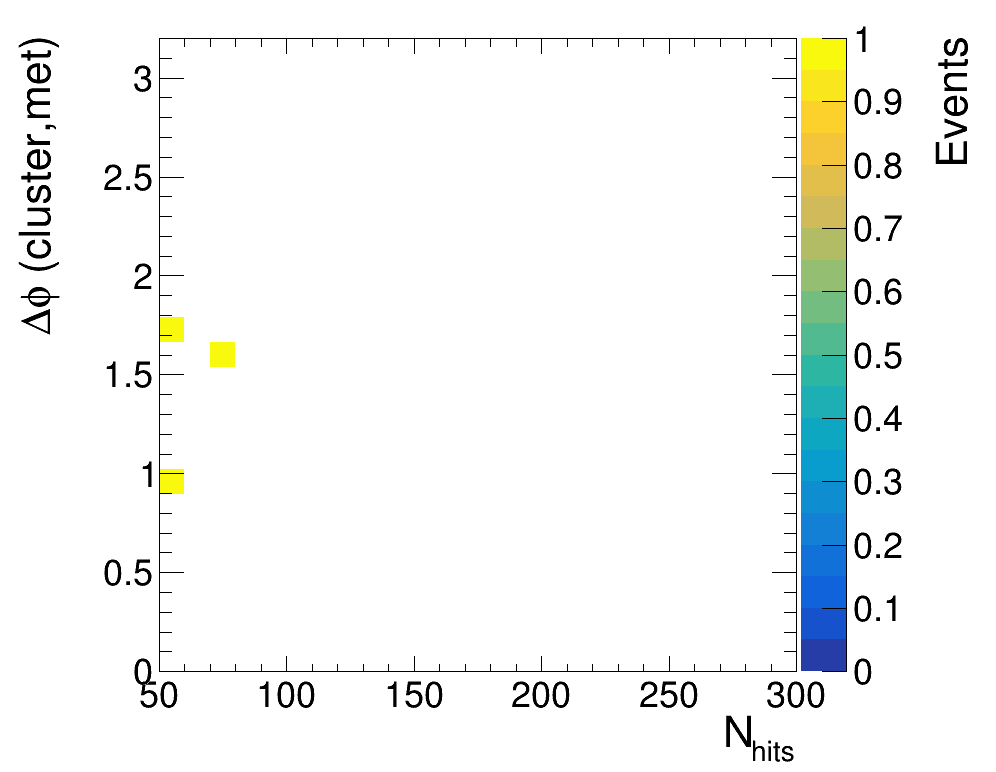

In [66]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)

h = rt.TH2D()
h = rt.TH2D('', '', 25,50,300,25,0,3.2)
h.SetXTitle('N_{hits}')
h.SetYTitle('#Delta#phi (cluster,met)')
h.SetZTitle('Events')
# h = create_TH2D(np.column_stack(( Nhits, np.abs(deltaPhi))),
#                axis_title = ['N_{rechits}','#Delta#phi (cluster,met)','Events'], binning=[25,50,300,25,0,3.2])
for i in range(len(Nhits)):
    h.Fill(Nhits[i],np.abs(deltaPhi)[i])

h.Draw('colz')
c.SetRightMargin(0.2)
c.Draw()

# c.SaveAs()



# ABCD (Scan Nrechits)

In [48]:
n_ev = 5000

scan_nhits = 1

if scan_nhits:
    dphi_scan = [0.75]
    nhits_scan = np.arange(60,300,10)
else:
    dphi_scan = np.arange(9,22,1)/20
    nhits_scan = [130]

    

for N_RECHIT_CUT in nhits_scan:
    for DPHI_CUT in dphi_scan:
        var = np.abs(deltaPhi)
        a = br * np.sum(np.logical_and(Nhits>=N_RECHIT_CUT, np.abs(deltaPhi)>=DPHI_CUT))
        b = br * np.sum(np.logical_and(Nhits<N_RECHIT_CUT, np.abs(deltaPhi)>=DPHI_CUT))
        c = br * np.sum(np.logical_and(Nhits<N_RECHIT_CUT, np.abs(deltaPhi)<DPHI_CUT))
        d = br * np.sum(np.logical_and(Nhits>=N_RECHIT_CUT, np.abs(deltaPhi)<DPHI_CUT))


        pred = c/b*a
        unc_pred = (1./c + 1./b + 1./a)**0.5*(pred)
        if math.isnan(unc_pred): z_value = float("nan")
        else:
            mu = np.random.normal(pred, unc_pred, n_ev)
            p_value = 0.0
            for i in mu:
                if i < 0:continue
                n = np.random.poisson(i, n_ev)
                p_value += np.count_nonzero(n>=d[k])

            p_value = p_value/n_ev**2
            z_value = abs(norm.ppf(p_value))
        print(N_RECHIT_CUT, '\t',a,'\t',b,'\t',c,'\t',d,'\t', round(pred, 2), '\t',\
              round( unc_pred, 2), '\t', round(z_value,2))



/tmp/ipykernel_14352/2743722681.py:24: RuntimeWarning: divide by zero encountered in true_divide
  unc_pred = (1./c + 1./b + 1./a)**0.5*(pred)
/tmp/ipykernel_14352/2743722681.py:24: RuntimeWarning: invalid value encountered in double_scalars
  unc_pred = (1./c + 1./b + 1./a)**0.5*(pred)


60 	 1 	 2 	 0 	 0 	 0.0 	 nan 	 nan
70 	 1 	 2 	 0 	 0 	 0.0 	 nan 	 nan
80 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
90 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
100 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
110 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
120 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
130 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
140 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
150 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
160 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
170 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
180 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
190 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
200 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
210 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
220 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
230 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
240 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
250 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
260 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
270 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
280 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
290 	 0 	 3 	 0 	 0 	 0.0 	 nan 	 nan
